  0%|          | 0/1048575 [00:00<?, ?it/s]

                        Date     Open     High      Low    Close  Volume  \
100  01.01.2010 01:42:00.000  1.43271  1.43279  1.43271  1.43278    20.0   
101  01.01.2010 01:43:00.000  1.43268  1.43271  1.43265  1.43269    38.4   
102  01.01.2010 01:44:00.000  1.43279  1.43288  1.43277  1.43282    16.9   
103  01.01.2010 01:45:00.000  1.43280  1.43280  1.43272  1.43272    29.3   
104  01.01.2010 01:46:00.000  1.43286  1.43296  1.43284  1.43284    11.3   
105  01.01.2010 01:47:00.000  1.43288  1.43302  1.43288  1.43296    35.2   
106  01.01.2010 01:48:00.000  1.43282  1.43287  1.43277  1.43287    29.5   
107  01.01.2010 01:49:00.000  1.43282  1.43289  1.43275  1.43275    74.8   
108  01.01.2010 01:50:00.000  1.43277  1.43281  1.43253  1.43257    38.9   
109  01.01.2010 01:51:00.000  1.43249  1.43249  1.43218  1.43218    17.0   

     Upper_shadow  Lower_shadow  Realbody  Direction  Upper_per  Lower_per  \
100       0.00001       0.00000   0.00007        1.0       46.0        0.0   
101    

  0%|          | 183/1048575 [00:00<09:34, 1825.57it/s]

The number of eveningstar: 1150
The number of bullishengulfing: 4


  0%|          | 760/1048575 [00:00<09:15, 1885.95it/s]

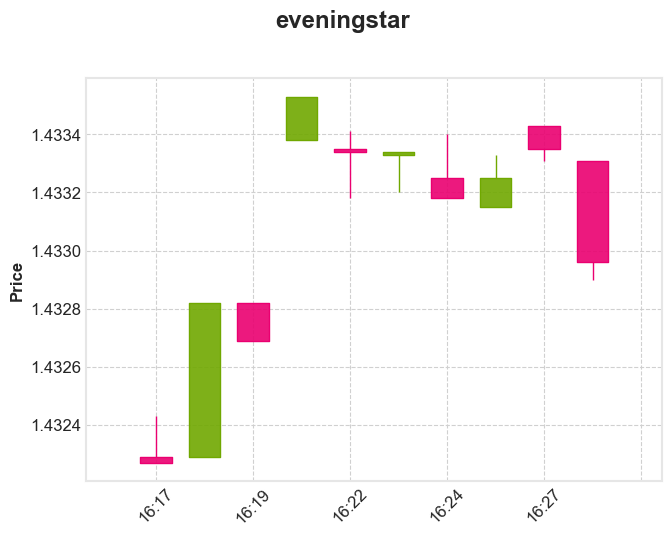

 10%|▉         | 100101/1048575 [00:44<06:51, 2305.51it/s]

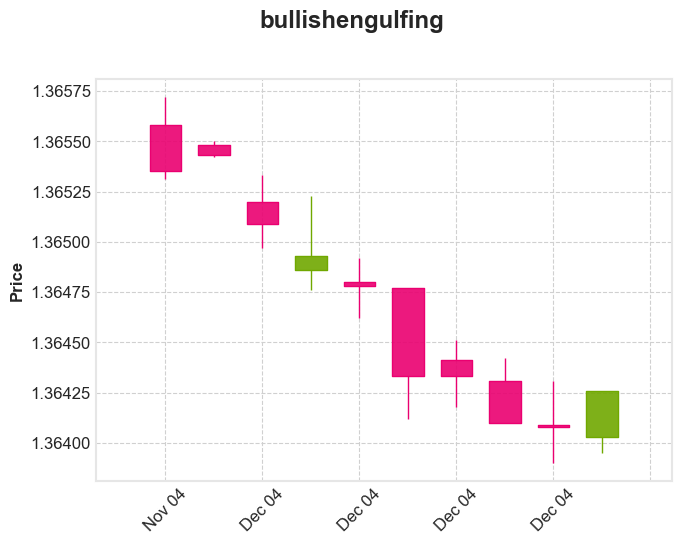

 10%|▉         | 100101/1048575 [01:00<06:51, 2305.51it/s]

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import mplfinance as mpf
import time
import matplotlib as mlt
from talib import abstract
from datetime import datetime

def percentile(series):
        t = series.iloc[-1]
        p = stats.percentileofscore(series, t, kind='strict')    
        return p


def trending(series):
    y = series.values.reshape(-1,1)
    x = np.array(range(1, series.shape[0] + 1)).reshape(-1,1)
    
    lm = LinearRegression()
    lm.fit(x,y)
    
    if lm.coef_ > 0:
        return 1
    elif lm.coef_ == 0:
        return 0
    else:
        return -1


def dataprocess(df):
    tall = df['Open'].combine(df['Close'],np.maximum)
    short = df['Close'].combine(df['Open'],np.minimum)


    df['Upper_shadow'] = df['High']-tall
    df['Lower_shadow'] = short-df['Low']
    df['Realbody'] = df['Close']-df['Open']
    df['Direction'] = np.sign(df['Realbody'])
    
    df['Upper_per'] = df['Upper_shadow'].rolling(50).apply(percentile, raw=False)
    df['Lower_per'] = df['Lower_shadow'].rolling(50).apply(percentile, raw=False)
    df['Realbody_per'] = df['Realbody'].rolling(50).apply(percentile, raw=False)
    
    df['Trend7'] = df['Close'].rolling(7).apply(trending, raw=False)
    df['Trend8'] = df['Close'].rolling(8).apply(trending, raw=False)
    df['Trend9'] = df['Close'].rolling(9).apply(trending, raw=False)
    
    print(df[100:110])
    
    df['Eveningstar'] = 0
    df['Bullishengulfing'] = 0
    df['None'] = 0
    
    return df

def eveningstar(df):
    cond1 = (df['Trend7'].iloc[-4] > 0)
    cond2 = (df['Direction'].iloc[-3] > 0)
    cond3 = (df['Direction'].iloc[-1] < 0)
    cond4 = (df['Realbody_per'].iloc[-3] >= 65)
    cond5 = (df['Realbody_per'].iloc[-2] <= 35)
    cond6 = (df['Close'].iloc[-1] <= (df['Open'].iloc[-3] + df['Realbody'].iloc[-3] * (1/2)))
    cond7 = (df['Close'].iloc[-3] <= (df['Open'].iloc[-2] + df['Realbody'].iloc[-2] * (1/2)))
    cond8 = (df['Open'].iloc[-1] <= (df['Open'].iloc[-2] + df['Realbody'].iloc[-2] * (1/2)))
    if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 and cond7 and cond8:
        return True
    else:
        return False

def bullishengulfing(df):
    cond1 = (df['Trend8'].iloc[-3] < 0)
    cond2 = (df['Direction'].iloc[-2] < 0)
    cond3 = (df['Direction'].iloc[-1] > 0)
    cond4 = (df['Realbody_per'].iloc[-2] >= 65)
    cond5 = (df['Open'].iloc[-1] < df['Close'].iloc[-2])
    cond6 = (df['Close'].iloc[-1] > df['Open'].iloc[-2])
    if cond1 and cond2 and cond3 and cond4 and cond5 and cond6:
        return True
    else:
        return False    

    
    
def signal(df):
    for idx in tqdm(df.index):
        start = idx-9
        end = idx
        if start >= 0:
            data = df.loc[start:end]
            if eveningstar(data):
                df.loc[end, 'Eveningstar'] = 1
            elif bullishengulfing(data):
                df.loc[end, 'Bullishengulfing'] = 1                
            else:
                df.loc[end, None] = 1
    return df

def counts(df):
    Eveningstar_counts = df['Eveningstar'].values.sum()
    Bullishengulfing_counts = df['Bullishengulfing'].values.sum()
    
    print('The number of eveningstar:',Eveningstar_counts)
    print('The number of bullishengulfing:',Bullishengulfing_counts)  
    return df 

def graph(df,signal):
    df_adj = df.iloc[:10,0:5]
    df_adj['Date'] = pd.to_datetime(df_adj['Date'])
    df_adj.set_index(['Date'], inplace=True)
    mpf.plot(df_adj, type='candle', style='binance', title=signal)


def graphresult(df):
    for idx in tqdm(df.index):
        start = idx-9
        end = idx
        if start >= 0:
            data = df.loc[start:end]
            if eveningstar(data):
                graph(data,'eveningstar')
                break
                
    for idx in tqdm(df.index):
        start = idx-9
        end = idx
        if start >= 0:
            data = df.loc[start:end]
            if bullishengulfing(data):
                graph(data,'bullishengulfing')
                break

df = pd.read_csv('data.csv')
df = dataprocess(df)

df = signal(df)

counts(df)

graphresult(df)